In [ ]:
import numpy as np
import torch
import time
import torchvision
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms as tt
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
os.getcwd()

'/content'

In [ ]:
# import functions and classes written by myslef
from data_preprocessing import load_npz_files, Dataset_Preprocessing, data_check_plot_tensor_figures
from GAN_training import Linear_GAN_training

#### Checking GPU info

In [ ]:
print('torch.cuda.is_available(): ' + str(torch.cuda.is_available()))

torch.cuda.is_available(): True


#### First thing: combine train, val, test as stated in plan.md

In [ ]:
current_dir = os.getcwd()
derma = load_npz_files(current_dir + '/dermamnist.npz')
derma.files

['train_images',
 'val_images',
 'test_images',
 'train_labels',
 'val_labels',
 'test_labels']

In [ ]:
 # I hereby to concatenate all 3 datasets
# because we do not need val/test in GAN, as its a unsupervised algorithm

train = derma['train_images'] # numpy array
val = derma['val_images']
test = derma['test_images']
# train_label = derma['train_labels']
concatenate_img = np.concatenate((train, val, test))
# concatenate_img = concatenate_img.reshape(10015, 3, 28, 28)
# thus we concatenate all the images

train shape:  (7007, 28, 28, 3)
image0 shape:  (28, 28, 3)


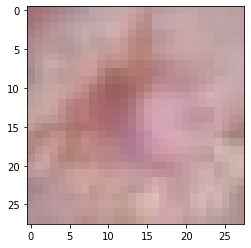

In [ ]:
print('train shape: ', train.shape)
print('image0 shape: ', concatenate_img[0].shape)
plt.imshow(concatenate_img[0])

In [ ]:
# Generator Settings
# Device -> will use in google colab
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print('Device:', DEVICE)

Device: cuda


### A linear GAN model

In [ ]:
# use fixed noise to generate
# if on GPU
fixed_noise = torch.randn(128, 100, 1, 1, device=DEVICE) # format NCHW
# noises are from a (128, 100, 1, 1) high-dimensional(latent dimension: 100-dimension) normal distribution with mean 0 and variance 1
# I randomly decide the dimension numbers -> but should keep consistency later
print('fixed noise shape: ', fixed_noise.shape)

# image size
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 28, 28, 3

fixed noise shape:  torch.Size([128, 100, 1, 1])


In [ ]:
# Lets generate random pictures with linear connection
class Linear_GAN(torch.nn.Module):

    def __init__(self, latent_dimension=100, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH, color_channels=IMAGE_CHANNELS):
        super().__init__()
        self.latent_dimension = latent_dimension
        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels
        
        self.generator = nn.Sequential(
            nn.Linear(latent_dimension, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, image_height*image_width*color_channels),
            nn.Tanh() # need to normalize imags with mean 0 and std 1
        )
        
        self.discriminator = nn.Sequential(
            nn.Flatten(), # NCHW -> N, C*H*W
            nn.Linear(image_height*image_width*color_channels, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1)
        )

    def generator_forward(self, z): # z has dimension NCHW
        z = torch.flatten(z, start_dim=1) 
        img = self.generator(z)
        img = img.view(z.size(0),
                       self.color_channels,
                       self.image_height,
                       self.image_width)
        return img
    
    def discriminator_forward(self,img):
        logits = self.discriminator(img)
        return logits


In [ ]:
# load up model for test
linear_generator = Linear_GAN()
linear_generator.to(DEVICE)
# generate fake images
# # 1. fake_images = Linear_GAN().generator_forward(fixed_noise)
fake_images = linear_generator.generator_forward(fixed_noise)


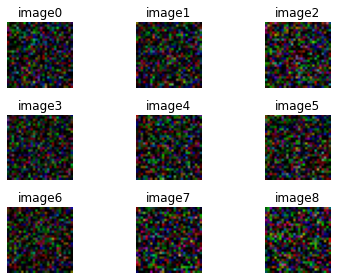

In [ ]:
# lets check 9 images of these fake images
number_of_img = 9
# data dictionary for plotting function
nine_fake_images_ = {'image'+str(i): fake_images[i] for i in range(number_of_img)}
# plot using data_check_plot_figures
data_check_plot_tensor_figures(nine_fake_images_, nrows = 3, ncols=3)

#### image visualizations

image0 shape:  torch.Size([3, 28, 28])


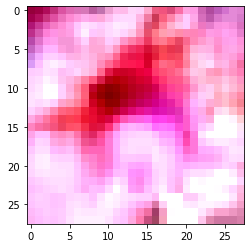

In [ ]:
# normalize images
# because they are medical images, it is better to calculate the mean and std of the dataset
# and use them to normalize the images, but here try to use convention 
img_preprocessing = tt.Compose([
    tt.ToTensor(), # -> automatically transform images to 3,28,28 from 28,28,3
    tt.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

img0 = img_preprocessing(concatenate_img[0])
print('image0 shape: ', img0.shape)
plt.imshow(img0.permute(-1,1,0))

#### custom data preprocessing

In [ ]:
# perform data standardization before into dataloader
concatenate_img_ = Dataset_Preprocessing(imgs=concatenate_img)

In [ ]:
BATCH_SIZE = 16
train = DataLoader(dataset=concatenate_img_, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

#### visualize the images after loaded 

In [ ]:
# make_grid is a very nice function in torchvision
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataset, nmax=64):
    for images in dataset:
        show_images(images, nmax)
        break

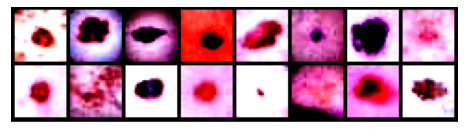

In [ ]:
show_batch(train)

In [ ]:
for batch_idx, imgs in enumerate(train):
    print('batch index number: ', batch_idx)
    print('batch shape: ', imgs.shape)
    break

batch index number:  0
batch shape:  torch.Size([16, 3, 28, 28])


### Train model
* will be separated in the future from this notebook

In [ ]:
# Generator parameters
RANDOM_SEED = 723
LATENT_DIMENSION= 100
NUM_EPOCHS = 100

GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

In [ ]:
# optimizers for both generator and discriminator
MODEL= Linear_GAN()
MODEL.to(DEVICE)

OPTIMIZER_GEN = torch.optim.Adam(MODEL.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

OPTIMIZER_DISCR = torch.optim.Adam(MODEL.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

In [ ]:
log_dict=Linear_GAN_training(data=train, model=MODEL, 
                     num_epochs=NUM_EPOCHS, 
                     latent_dim=LATENT_DIMENSION, 
                     optim_discr=OPTIMIZER_DISCR,
                     optim_gen=OPTIMIZER_GEN,
                     device=DEVICE)

Epoch: 001/100 | Batch 000/626 | Gen/Dis Loss: 0.7566/0.6019
Epoch: 001/100 | Batch 100/626 | Gen/Dis Loss: 0.7261/0.3900
Epoch: 001/100 | Batch 200/626 | Gen/Dis Loss: 0.9660/0.3068
Epoch: 001/100 | Batch 300/626 | Gen/Dis Loss: 1.2222/0.2312
Epoch: 001/100 | Batch 400/626 | Gen/Dis Loss: 1.4023/0.1993
Epoch: 001/100 | Batch 500/626 | Gen/Dis Loss: 1.1976/0.2464
Epoch: 001/100 | Batch 600/626 | Gen/Dis Loss: 1.3308/0.2141
Time elapsed: 0.07 min
Epoch: 002/100 | Batch 000/626 | Gen/Dis Loss: 1.3366/0.2519
Epoch: 002/100 | Batch 100/626 | Gen/Dis Loss: 1.1174/0.2489
Epoch: 002/100 | Batch 200/626 | Gen/Dis Loss: 1.4412/0.2378
Epoch: 002/100 | Batch 300/626 | Gen/Dis Loss: 1.4762/0.2744
Epoch: 002/100 | Batch 400/626 | Gen/Dis Loss: 1.2920/0.3074
Epoch: 002/100 | Batch 500/626 | Gen/Dis Loss: 0.9464/0.4132
Epoch: 002/100 | Batch 600/626 | Gen/Dis Loss: 1.3443/0.2849
Time elapsed: 0.13 min
Epoch: 003/100 | Batch 000/626 | Gen/Dis Loss: 1.4737/0.2520
Epoch: 003/100 | Batch 100/626 | Gen/Di

In [ ]:
for i in range(0, 100, 10):
    
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()
    
    
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fake_images_ = MODEL.generator_forward(fixed_noise).detach().cpu()
fake_images_.shape

torch.Size([128, 3, 28, 28])

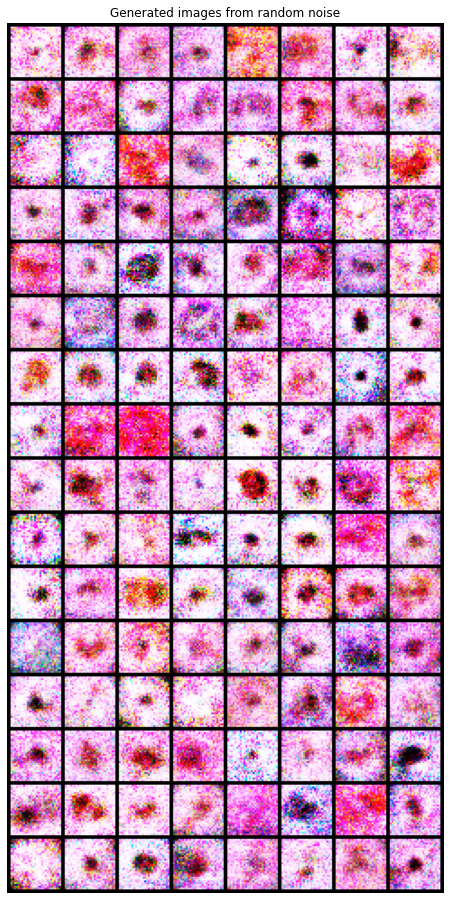

In [ ]:
plt.figure(figsize=(25, 16))
plt.axis('off')
plt.title(f'Generated images from random noise')
plt.imshow(np.transpose(torchvision.utils.make_grid(fake_images_, padding=2, normalize=True), (1, 2, 0)))